#  Исследование трендов рынка комьютерных игр
На основе анализа исторических данных о продажах игр, их оценках, жанрах и платформах, выявить определяющие успешность игры закономерности.

# Оглавление:
* [Шаг 1. Общая информация](#1)
* [Шаг 2. Предобработка.](#2)
* [Шаг 3. Исследовательский анализ данных.](#3)
    - [3.1 Сколько игр выпускалось в разные годы](#3.1)
    - [3.2 Какие платформы  актуальны](#3.2)
    - [3.3 Анализ 2013-2016 годов](#3.3) 
        - [3.3.1 Как меняются продажи по платформам](#3.3.1) 
        - [3.3.2 Как меняется количество игр по платформам](#3.3.2) 
        - [3.3.3 Стоимость игр на разных платформах](#3.3.3) 
        - [3.3.4 Влияние отзывов пользователей и критиков на продажи](#3.3.4) 
* [Шаг 4. Портрет пользователя каждого региона.](#4)
    - [4.1 Топ-5 платформ](#4.1)
    - [4.2 Топ-5 жанров](#4.2)
    - [4.3 Рейтинг ESRB](#4.3)
* [Шаг 5. Проверка гипотез.](#5)
* [Шаг 6. Общие выводы.](#6)

# 1. Общая информация <a class="anchor" id="1"></a>

Откроем файл с данными и изучим общую информацию.

In [1]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import scipy.stats as st
import math
 

df=pd.read_csv('datasets/games.csv')
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 16715 entries, 0 to 16714
Data columns (total 11 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   Name             16713 non-null  object 
 1   Platform         16715 non-null  object 
 2   Year_of_Release  16446 non-null  float64
 3   Genre            16713 non-null  object 
 4   NA_sales         16715 non-null  float64
 5   EU_sales         16715 non-null  float64
 6   JP_sales         16715 non-null  float64
 7   Other_sales      16715 non-null  float64
 8   Critic_Score     8137 non-null   float64
 9   User_Score       10014 non-null  object 
 10  Rating           9949 non-null   object 
dtypes: float64(6), object(5)
memory usage: 1.4+ MB


<b>Вывод:</b>
<li>Столбцы с годом и рейтингом пользователей находятся не в оптимальных для данных параметров типах данных.
<li>Только половина игр имеют рейтинг в системе ESRB и оценки критиков/экспертов
<li> Количество пропусков в годах и жанрах незначительное (меньше 5%), поэтому критичной необходимости заполнять эти пропуски нет    


# 2. Предобработка <a class="anchor" id="2"></a>
#### 2.1 Заменим названия столбцов (приведем к нижнему регистру)

In [2]:
df.columns=df.columns.str.lower()

#### 2.2 Обработаем пропуски

<li> Оценки могут быть пропущены у слишком нишевых или непопулярных игр, которые провалились. Если получится выснить причину пропуска, то можно подумать над корректной заменой. Пока в столбцах с оценками пользователей пропуски лучше оставить, чтобы не исказить результаты. 
<li> Исходя из названия аббревиатура 'tbd' в столбцах с оценкой пользователей выдается, когда рейтинг в процессе подсчета. Чтобы строка не мешала обработке при вычислениях со столбцом, заменим  'tbd' на NaN


In [3]:
df.user_score.replace('tbd', np.nan, inplace=True)

#### 2.3 Преобразуем в нужные типы

<li> Преобразуем year_of_release в целочисленный вид int
<li>Преобразуем <i>user_score</i> в float, чтобы проводить вычисления над данным (считать среднее и тд)


In [4]:
df.year_of_release=df.year_of_release.astype('Int64')
df.user_score=df.user_score.apply(pd.to_numeric, errors='coerce')

df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 16715 entries, 0 to 16714
Data columns (total 11 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   name             16713 non-null  object 
 1   platform         16715 non-null  object 
 2   year_of_release  16446 non-null  Int64  
 3   genre            16713 non-null  object 
 4   na_sales         16715 non-null  float64
 5   eu_sales         16715 non-null  float64
 6   jp_sales         16715 non-null  float64
 7   other_sales      16715 non-null  float64
 8   critic_score     8137 non-null   float64
 9   user_score       7590 non-null   float64
 10  rating           9949 non-null   object 
dtypes: Int64(1), float64(6), object(4)
memory usage: 1.4+ MB


In [5]:
df.describe()

,year_of_release,na_sales,eu_sales,jp_sales,other_sales,critic_score,user_score
count,16446.000000,16715.000000,16715.000000,16715.000000,16715.000000,8137.000000,7590.000000
mean,2006.484616,0.263377,0.145060,0.077617,0.047342,68.967679,7.125046
std,5.877050,0.813604,0.503339,0.308853,0.186731,13.938165,1.500006
min,1980.000000,0.000000,0.000000,0.000000,0.000000,13.000000,0.000000
25%,2003.000000,0.000000,0.000000,0.000000,0.000000,60.000000,6.400000
50%,2007.000000,0.080000,0.020000,0.000000,0.010000,71.000000,7.500000
75%,2010.000000,0.240000,0.110000,0.040000,0.030000,79.000000,8.200000
max,2016.000000,41.360000,28.960000,10.220000,10.570000,98.000000,9.700000


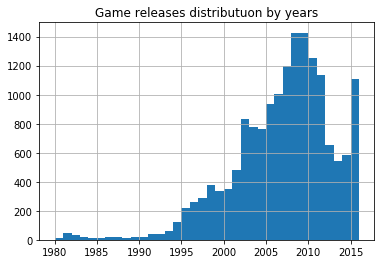

In [6]:
(df['year_of_release'].hist(bins=36)
     .set(title='Game releases distributuon by years'));

<b>Вывод:</b>

<li> По описательным статистикам видим большой разброс в выручке
<li> распределение годов скошено влево, 75% игр в данных, выпущены после 2003 года, но не позднее 2016. 
<li> вероятно в разных странах продажи значимо раздичаются, и похоже наибольший доход приносят продажи в Штатах

#### 2.4 Посчитаем суммарные продажи

In [7]:
df['total_sales']=df.na_sales+df.eu_sales+df.jp_sales+df.other_sales

In [8]:
df['total_sales'].describe()

count    16715.000000
mean         0.533396
std          1.548261
min          0.000000
25%          0.060000
50%          0.170000
75%          0.470000
max         82.540000
Name: total_sales, dtype: float64

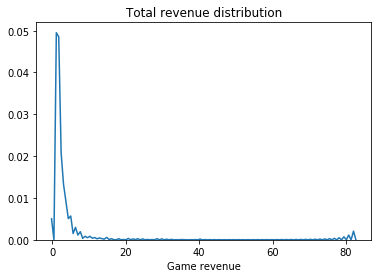

In [9]:
(sns.distplot(df['total_sales'], hist=False)
     .set(title='Total revenue distribution', xlabel='Game revenue'));

Распределение суммарных продаж скошено право, есть игры с общим доходом 0, у 75% игр из выборки продажи не превысилм 500 тысяч долларов.

# 3. Исследовательский анализ данных <a class="anchor" id="3"></a>

### 3.1 Сколько игр выпускалось в разные годы <a class="anchor" id="3.1"></a>

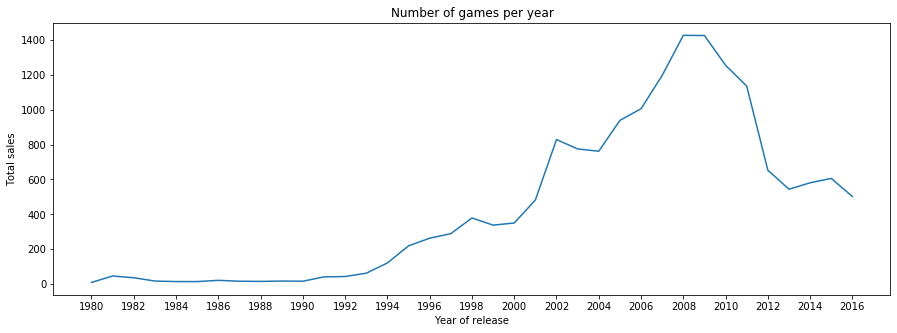

In [10]:
(df.pivot_table(index='year_of_release', values='total_sales', aggfunc='count')
     .plot(title = 'Number of games per year', legend=False, figsize=(15,5))
     .set(xlabel='Year of release', ylabel='Total sales'))

plt.xticks([y for y in range(1980,2017)[1980%2::2]]);

<b>Вывод:</b>
<li>Индустрия игр в целом имеет падающий тренд начиная с 2008 год, игр с каждым годом производится все меньше
<li> Максимальное количество игр в выборке было выпущено между 2006 и 2011 годами.
<li> Резкий скачок в индустрии произошел в 1993, 2001, 2004 и 2006 годах.
<li> до 1993 года количество игр выпускаемых игр в год было стабильно
<li> Наиболее важны данные за последние 10 лет, с 2006 по 2016 годы. В них попадает 50% игр из выборки, более ранние игры не имеет смысл рассматривать в виду значительных изменений, произошедших в индустрии и в обществе за это время.    

### 3.2 Какие платформы  актуальны: Топ-10 по продажам  <a class="anchor" id="3.2"></a>

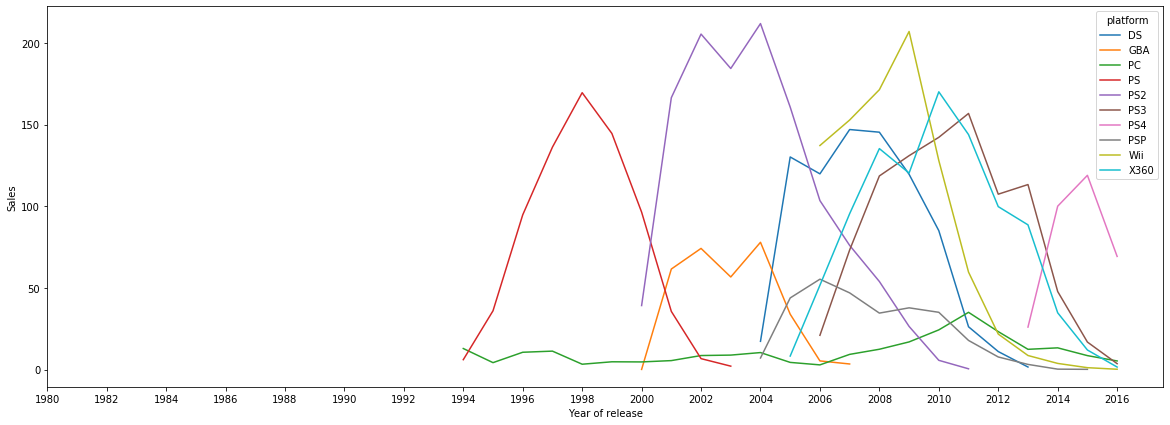

In [11]:
# создадим датафрейм с группировкой суммарных продаж по платформам и годам
sales_by_platform=(df.pivot_table(index='platform', columns='year_of_release', values='total_sales', aggfunc='sum')
                   .reset_index())

# построим график динамики суммарных продаж по годам, для платформ с самыми высоким продажами
# создалим объект series с топ-10 платформами по продажам, запишем в него имена и сумму продаж
best_platforms=(df.groupby('platform')['total_sales']
                .sum()
                .sort_values(ascending=False)[:10]
                .reset_index())

# отметим в датафрейме те платформы, которые вошли в топ-10 и выведем график продаж по годам
sales_by_platform['top10'] = (sales_by_platform.platform.isin(best_platforms.platform) == True)
(sales_by_platform[sales_by_platform['top10']==True]
     .set_index('platform').T.drop('top10')
     .plot(figsize=(20,7))
     .set(xlabel='Year of release', ylabel='Sales'))
plt.xticks([y for y in range(1980,2017)[1980%2::2]]);

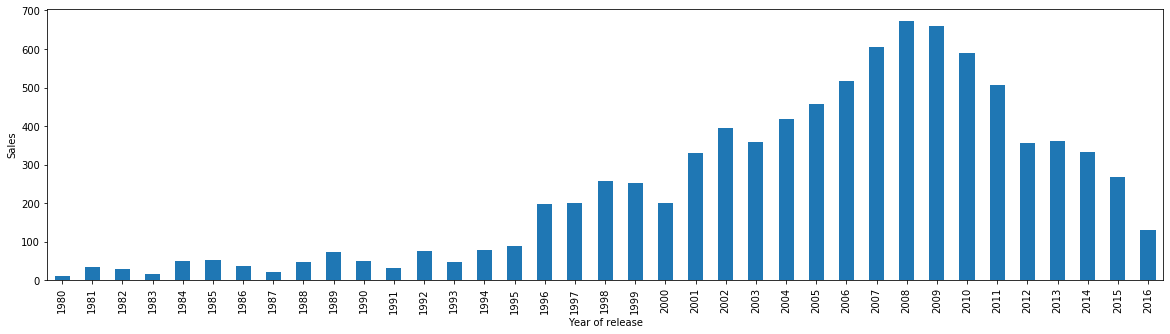

In [12]:
(sales_by_platform.set_index('platform')
     .drop(columns='top10')
     .sum()
     .plot(kind ='bar', figsize=(20,5))
     .set(xlabel='Year of release', ylabel='Sales'));


<b>Вывод:</b>
<li>Продажи игр начали активно расти после 1994 года.
<li>Суммарные продажи положительно коррелируют к количеством выпускаемых игр    
<li>Среднее время жизнии платформы - около 10 лет. 
<li>Продажи на большинстве платформ достигают пика в течение первых 2-3 лет после запуска, какое-то время находятся в точке максимума и затем постепенно снижаются. 
<li>Исключение - платформа PC, она существует с 1994 года, в 2011 году пережила пик, а в остальное время стабильно держит планку по продажам игр на ней.

### 3.3 Анализ 2013-2016 годов <a class="anchor" id="3.3"></a>

Среднее время жизни платформы 10 лет, однако мир видеоигр - очень динамичный. Исходя их прошлых графиков, некоторые плотформы появились только в 2013г. При планировании 2017 года для принятия окончательного решения необходимо в первую очередь брать в расчет платформы и жанры, актуальные на 2016 год, поэтому проанализируем период за последние 4 года - с 2013 по 2016 годы.


In [13]:
#сохраним в отдельный датафрейм те игры, которые были выпущены после 2013 года
list_of_years=[ y for y in range(2013, 2017)]
df_2013_2016=df[df['year_of_release'].isin(list_of_years)]

### 3.3.1 Как меняются продажи по платформам <a class="anchor" id="3.3.1"></a>

platform
PS4     314.14
PS3     181.43
XOne    159.32
3DS     143.25
X360    136.80
dtype: float64

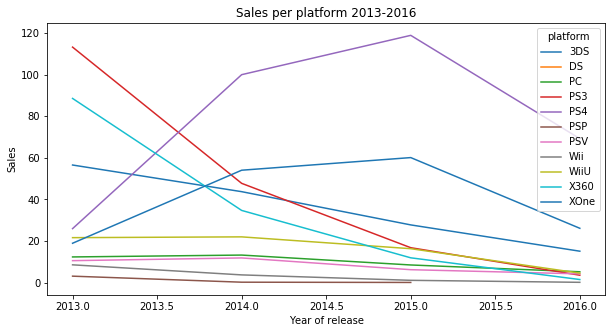

In [14]:
#построим график продаж для платформ по годам с 2013 года
platforms_2013_2016=df_2013_2016.pivot_table(index='platform', columns='year_of_release', values='total_sales', aggfunc='sum')

(platforms_2013_2016.T
     .plot(figsize=(10,5), title='Sales per platform 2013-2016')
     .set(xlabel='Year of release', ylabel='Sales'));

platforms_2013_2016.T.sum().sort_values(ascending=False).head()

### 3.3.2 Как меняется количество игр по платформам <a class="anchor" id="3.3.2"></a>

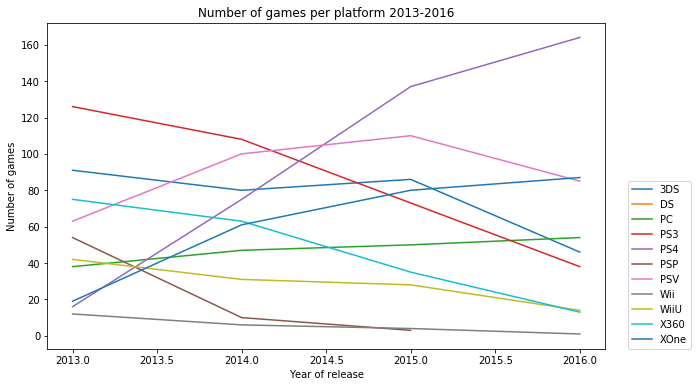

In [15]:
games_by_platform_2013_2016=df_2013_2016.pivot_table(index='platform', columns='year_of_release', values='name', aggfunc='count')

ax=games_by_platform_2013_2016.T.plot(figsize=(10,6), title='Number of games per platform 2013-2016');
ax.set(xlabel='Year of release', ylabel='Number of games')
plt.legend(loc=(1.04,0));

<b>Вывод:</b>
<li> лидерами по глобальным продажам в период с 2013 по 2016 год являются PS4, PS3, Xone, 3DS/
<li> продажи по всем платформам, кроме PS4 и  3DS падали. 
<li> PS4 и  3DS - новые платформы которые активно росли в продажах до 2016 год, однако в 2016 тоже начали падать. тем не менее они сохраняют за собой большую часть рынка.
<li> <b> PS4 и  3DS также активнее других развиваются, приращивают количество игр и являются наиболее перспективными.

###  3.3.3 Стоимость игр на разных платформах <a class="anchor" id="3.3.3"></a>

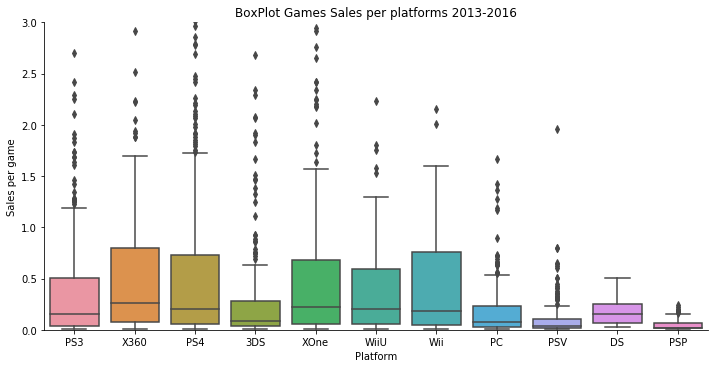

In [16]:
ax=sns.catplot(x="platform", y="total_sales",
            kind="box", dodge=False, data=df_2013_2016, height=5, aspect=2)\
            .set(title='BoxPlot Games Sales per platforms 2013-2016', ylim=(0,3))
ax.set(xlabel='Platform', ylabel='Sales per game');

<b>Вывод:</b>
<li> лидерами по средней стоимости за игру в период с 2013 по 2016 год являются X360, Wii, Xone, PS4, PS3.
<li> самая низкая стоимость игры в среднем на PC и PSV, при этом по количеству игр выпущенных в 2016 году платформа PC занимает 4 место.


### 3.3.4 Влияние отзывов пользователей и критиков на продажи <a class="anchor" id="3.3.4"></a> 

#### Влияние отзывов пользователей и критиков на продажи игр на платформе PS4

In [17]:
#Создадим новый столбец с суммой нормированных отзывов пользователей и критиков
df_2013_2016['total_score']=df_2013_2016['critic_score']+ df_2013_2016['user_score']*10

#выделим в отдельный датафрейм игры для PS4
PS4_2013_2016=df_2013_2016.query('platform=="PS4"')
PS4_2013_2016[PS4_2013_2016.columns[4:]].corr()

C:\Users\vslay\anaconda3\lib\site-packages\ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


,na_sales,eu_sales,jp_sales,other_sales,critic_score,user_score,total_sales,total_score
na_sales,1.000000,0.785362,0.472981,0.944259,0.415008,-0.020933,0.928160,0.203432
eu_sales,0.785362,1.000000,0.464563,0.944698,0.346720,-0.048925,0.958157,0.150598
jp_sales,0.472981,0.464563,1.000000,0.496467,0.322358,0.171332,0.527129,0.274939
other_sales,0.944259,0.944698,0.496467,1.000000,0.409191,-0.035639,0.998051,0.191432
critic_score,0.415008,0.346720,0.322358,0.409191,1.000000,0.557654,0.406568,0.863295
user_score,-0.020933,-0.048925,0.171332,-0.035639,0.557654,1.000000,-0.031957,0.900358
total_sales,0.928160,0.958157,0.527129,0.998051,0.406568,-0.031957,1.000000,0.192338
total_score,0.203432,0.150598,0.274939,0.191432,0.863295,0.900358,0.192338,1.000000


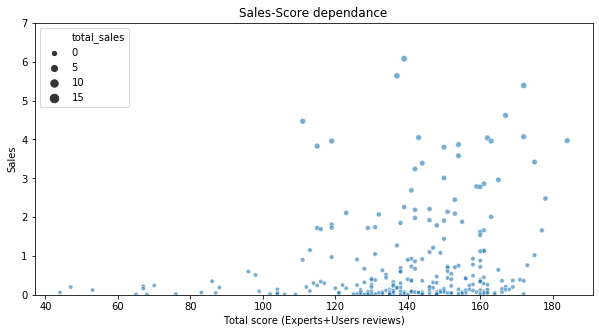

In [18]:
fig,ax=plt.subplots(figsize=(10,5))
sns.scatterplot(x="total_score", y="total_sales", size="total_sales", data=PS4_2013_2016, alpha=0.6).set(ylim=(0,7));
ax.set(xlabel='Total score (Experts+Users reviews)', ylabel='Sales', title='Sales-Score dependance');

<b>Вывод:</b>
<li> Корреляция между отзывами и глобальными продажами средняя положительная - 0.3
<li> Отзывы критиков вляют на продажи сильнее, чем отзывы пользователей. Отзывы пользователей практически не вляют на продажи нигде, кроме Японии.
<li> Жители Японии обращают внимание на оценки как критиков, так и пользователей, но так же больше доверяют критикам (это отличие от корреляций 2006-2016 года, раньше японцы меньше обращали внимание на отзывы критиков) 
<li> Все игры с самыми крупными продажами имеют суммарный рейтинг выше среднего (или выше 110) 
<li> Большая часть игр имеют глобальные продаж до 4 миллионов и средний рейтинг от 110 до 170 баллов

#### Влияние отзывов пользователей и критиков на продажи игр на других платформах

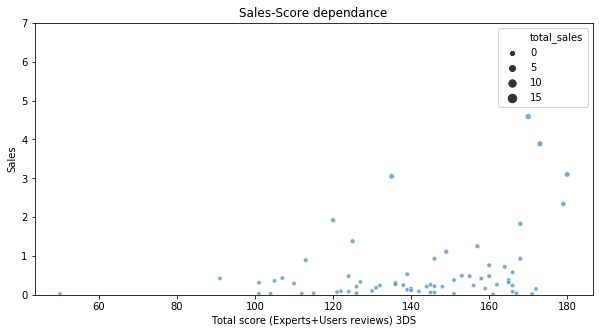

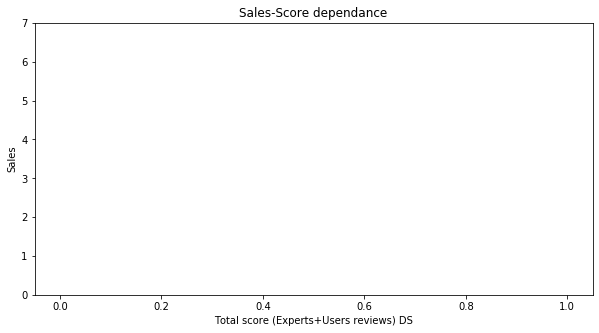

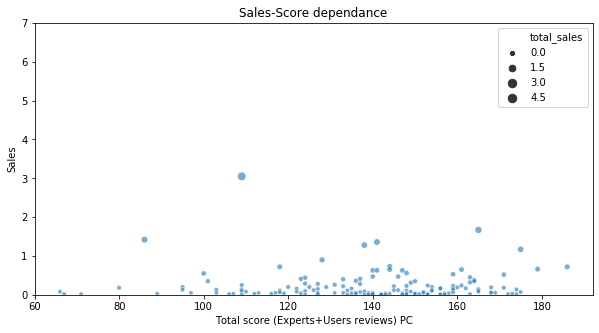

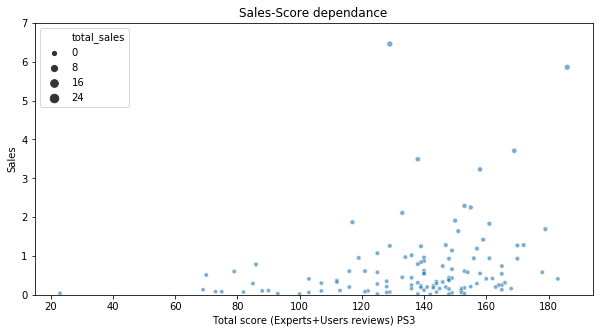

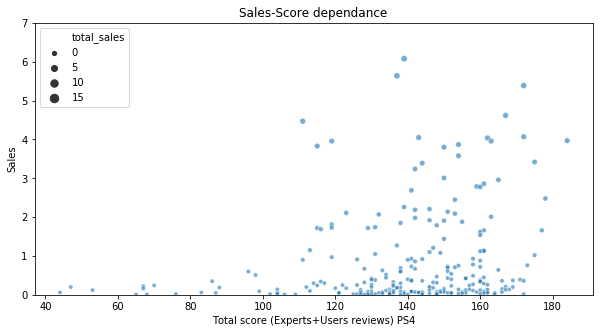

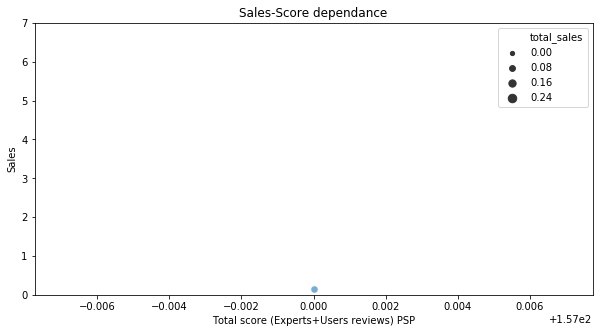

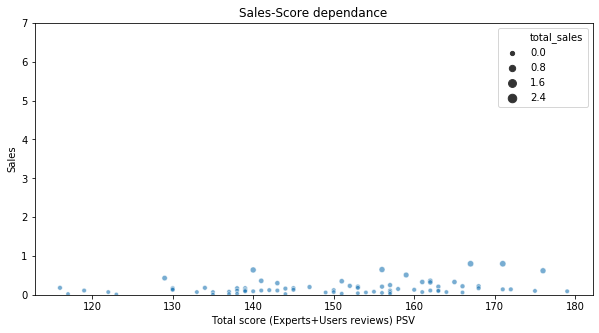

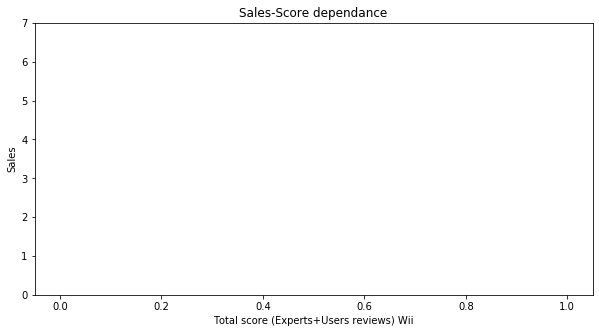

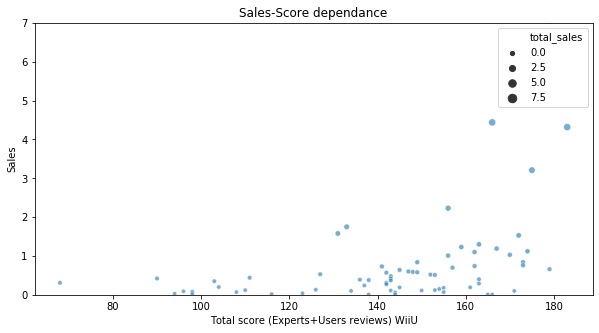

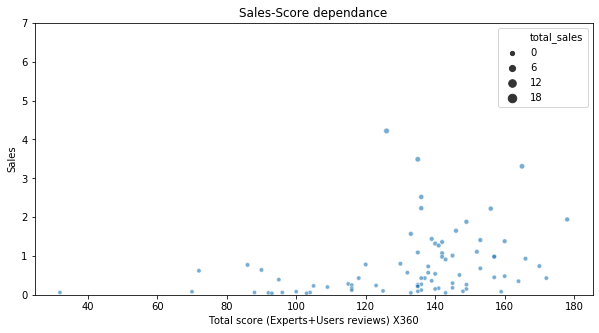

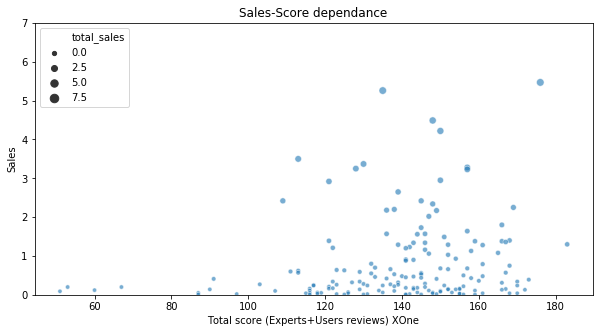

In [19]:
for p in platforms_2013_2016.index:
    plat_2013_2016=df_2013_2016.query('platform==@p')
    fig,ax=plt.subplots(figsize=(10,5))
    (sns.scatterplot(x="total_score", y="total_sales", size="total_sales", data=plat_2013_2016, alpha=0.6)
         .set(ylim=(0,7), title=p))
    ax.set(xlabel='Total score (Experts+Users reviews) ' + p, ylabel='Sales', title='Sales-Score dependance');


<b>Вывод:</b>
<li> Игры на PC и PSV не имеют корреляции с оценками.
<li> Игры на Х360, добившиеся высоких продаж, в среднем имеют более высокий рейтинг, чем игры с аналогичными продажами на PS4.    
  

### 3.4 Самые популярные, прибыльные и дорогие жанры игр  <a class="anchor" id="3.4"></a>

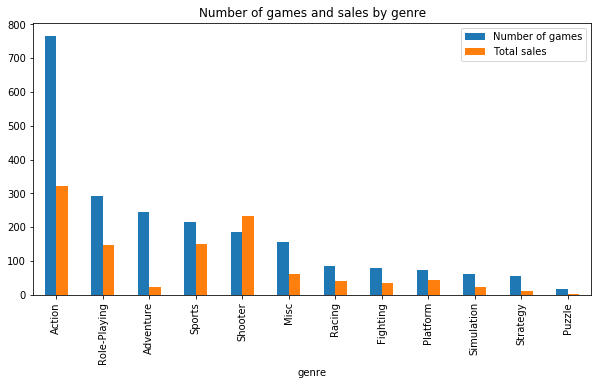

In [20]:
genres_2013_2016=df_2013_2016.pivot_table(index='genre', values='total_sales', aggfunc=('count','sum'))
genres_2013_2016.columns=('Number of games', 'Total sales')

(genres_2013_2016.sort_values(by='Number of games', ascending=False)
     .plot(kind='bar', figsize=(10,5), title='Number of games and sales by genre'));

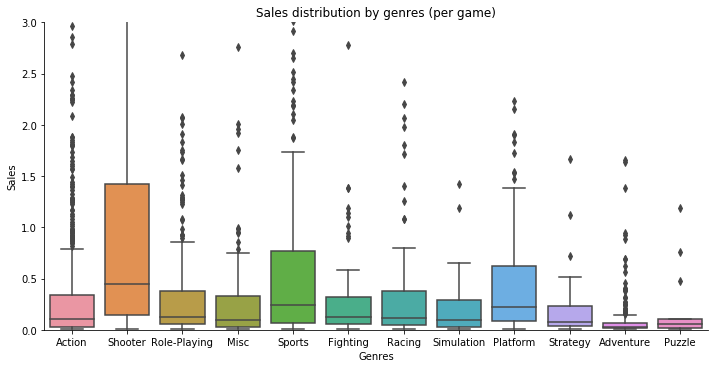

In [21]:
ax=sns.catplot(data=df_2013_2016, x='genre', y='total_sales', kind="box", height=5, aspect=2).set(ylim=(0,3))
ax.set(xlabel='Genres', ylabel='Sales', title='Sales distribution by genres (per game)');

<b>Вывод:</b>
<li>Больше всего игр выпускается в жанре Action, но и рынок игр этого жанра занимает самую бОльшую долю по продажам.
<li>На втором  и третьем месте ролевые игры и приключения, однако размер их продаж невелик и значительно уступает шутерам и спорту.
<li> В среднем самые прибыльные жанры - это шутеры и спорт, а самые неприбыльные -приключения и паззлы.     
    
  

## 4. Портрет пользователя каждого региона <a class="anchor" id="4"></a>
### на данных 2013-2016 года


### 4.1 Топ-5 платформ  <a class="anchor" id="4.1"></a>
#### Топ-5 платформ 2013-2016

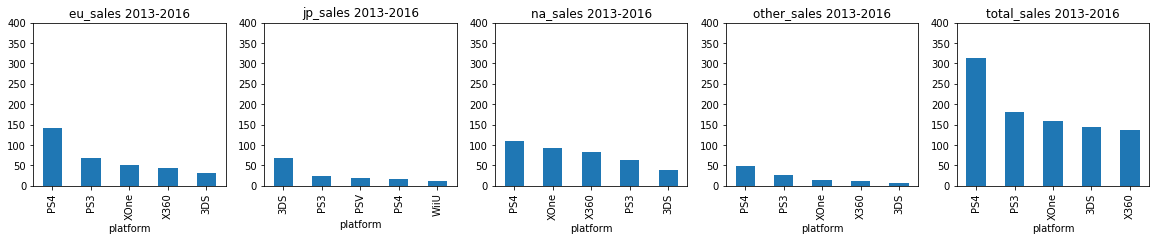

In [22]:
#создадим сводную таблицу, где рассчитаем продажи по каждой платформе
sales_by_reg_2013_2016=(df_2013_2016
                        .pivot_table(index='platform', \
                                     values=('na_sales','eu_sales', 'jp_sales','other_sales','total_sales'), aggfunc='sum' ));

#выведем на печать топ 5 платформ по продажам для каждого региона
plt.figure(figsize=(20, 3))
for i, reg in enumerate(sales_by_reg_2013_2016.columns, 1):
    plt.subplot(1, 5, i)
    (sales_by_reg_2013_2016[reg].sort_values(ascending=False)
         .head(5)
         .plot(kind='bar', title=reg+' 2013-2016', x=plt.gca(),ylim=(0,400)))
   


In [23]:
#Вычислим сумму продаж по каждому рынку и посчитаем аффинити ддя каждой из платформ на каждом рынке
affinity_by_reg_2013_2016=df_2013_2016.pivot_table(index='platform', values=('na_sales','eu_sales', 'jp_sales','other_sales'), aggfunc='sum' ).T
affinity_by_reg_2013_2016['total_sales_in_stock']=affinity_by_reg_2013_2016.sum(axis=1)
affinity_by_reg_2013_2016[['3DS_aff','DS_aff','PC_aff','PS3_aff','PS4_aff',\
                           'PSP_aff','PSV_aff','Wii_aff','WiiU_aff','X360_aff','XOne_aff']]\
                        =affinity_by_reg_2013_2016[['3DS','DS','PC','PS3','PS4',\
                                                    'PSP','PSV','Wii','WiiU','X360','XOne']]\
                        .apply(lambda x: x/(affinity_by_reg_2013_2016['total_sales_in_stock']/11), result_type='expand')

affinity_by_reg_2013_2016

platform,3DS,DS,PC,PS3,PS4,PSP,PSV,Wii,WiiU,X360,...,DS_aff,PC_aff,PS3_aff,PS4_aff,PSP_aff,PSV_aff,Wii_aff,WiiU_aff,X360_aff,XOne_aff
eu_sales,30.96,0.85,25.36,67.81,141.09,0.17,6.10,5.93,19.85,42.52,...,0.023838,0.711215,1.901716,3.956837,0.004768,0.171073,0.166305,0.556689,1.192464,1.446830
jp_sales,67.81,0.00,0.00,23.35,15.96,3.29,18.59,0.05,10.88,0.51,...,0.000000,0.000000,1.824478,1.247052,0.257068,1.452550,0.003907,0.850121,0.039849,0.026566
na_sales,38.20,0.57,11.11,63.50,108.74,0.00,5.04,6.56,29.21,81.66,...,0.014325,0.279203,1.595805,2.732723,0.000000,0.126659,0.164858,0.734071,2.052181,2.340180
other_sales,6.28,0.12,2.96,26.77,48.35,0.04,3.26,1.12,4.69,12.11,...,0.011003,0.271401,2.454530,4.433192,0.003668,0.298908,0.102692,0.430024,1.110361,1.308410


### 4.2 Топ-5 жанров 2013-2016 <a class="anchor" id="4.2"></a>

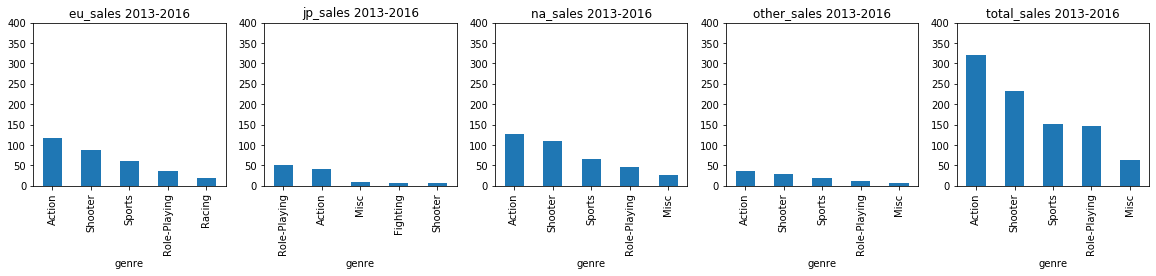

In [24]:
#создадим сводную таблицу, где рассчитаем продажи по каждому жанру
genres_by_reg_2013_2016=df_2013_2016.pivot_table(index='genre', values=('na_sales','eu_sales', 'jp_sales','other_sales','total_sales'), aggfunc='sum' )

#выведем на печать топ 5 платформ по продажам для каждого региона
plt.figure(figsize=(20, 3))
for i, reg in enumerate(genres_by_reg_2013_2016.columns, 1):
    plt.subplot(1, 5, i)
    (genres_by_reg_2013_2016[reg].sort_values(ascending=False)
                                 .head(5)
                                 .plot(kind='bar', title=reg+' 2013-2016', x=plt.gca(),ylim=(0,400)));
   


In [25]:
#Вычислим сумму продаж по каждому рынку и посчитаем аффинити ддя каждой из платформ на каждом рынке
affinity_genres_2013_2016=df_2013_2016.pivot_table(index='genre', values=('na_sales','eu_sales', 'jp_sales','other_sales'), aggfunc='sum' ).T
affinity_genres_2013_2016['total_sales_in_stock']=affinity_genres_2013_2016.sum(axis=1)
affinity_genres_2013_2016[['Action','Adventure','Fighting','Misc','Platform','Puzzle','Racing','Role-Playing','Shooter','Simulation','Sports','Strategy']]=affinity_genres_2013_2016[['Action','Adventure','Fighting','Misc','Platform','Puzzle','Racing','Role-Playing','Shooter','Simulation','Sports','Strategy']].apply(lambda x: x/(affinity_genres_2013_2016['total_sales_in_stock']/12), result_type='expand')
affinity_genres_2013_2016

genre,Action,Adventure,Fighting,Misc,Platform,Puzzle,Racing,Role-Playing,Shooter,Simulation,Sports,Strategy,total_sales_in_stock
eu_sales,3.614104,0.252403,0.261581,0.613110,0.476659,0.030594,0.617699,1.131071,2.688015,0.334090,1.851567,0.129108,392.23
jp_sales,3.451343,0.496093,0.652081,0.784202,0.408297,0.100582,0.196051,4.350618,0.563432,0.385282,0.461145,0.150874,140.78
na_sales,3.455713,0.195746,0.426310,0.753650,0.497316,0.022755,0.355304,1.272075,3.008567,0.133239,1.789404,0.089923,437.71
other_sales,3.720930,0.243061,0.356089,0.609152,0.412103,0.016004,0.444111,1.148287,2.877719,0.146037,1.945486,0.081020,119.97


### 4.3 Рейтинг ESRB <a class="anchor" id="4.3"></a>

In [26]:
country_labels=['North America','Europe', 'Japan','Other countries']

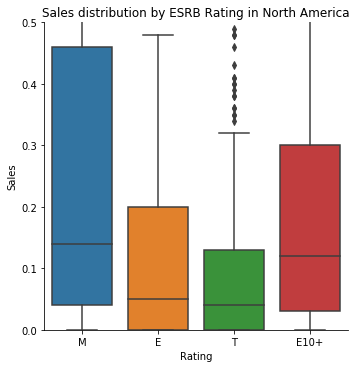

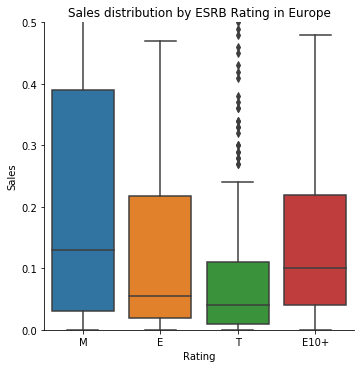

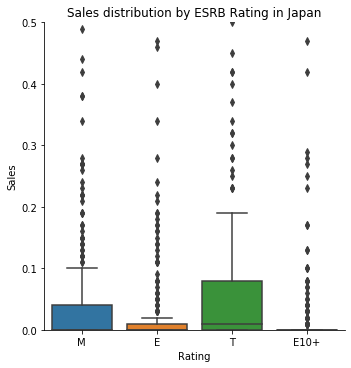

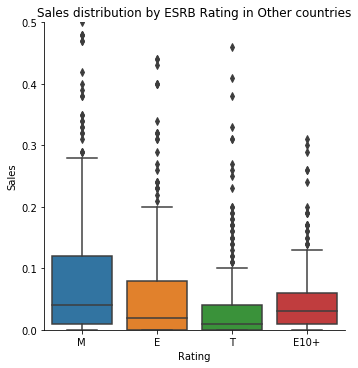

In [27]:
for i, y in zip(df_2013_2016.columns[4:8], country_labels):
    ax=sns.catplot(kind='box', data=df_2013_2016, x='rating', y=i).set(ylim=(0,0.5))
    ax.set(xlabel='Rating', ylabel='Sales', title='Sales distribution by ESRB Rating in '+ y);

<b>Вывод:</b>
<li> Пользователи на американском рынке любяи платформы PS4, X360 и Xone и игры в жанрах экшн и шутеры, по рейтингу ESRB наибольшей популярностью пользуются игры для взрослых и детей 10+
<li> Пользователи из Европы похожи на американцев. Но они чаще всего используют приставку PS4, несколько меньше в ходу X360 и Xone. Жанры экш и шутеры с маркировкаой для взрослых и детей 10+ в лидерах, как и в Штатах.
<li> Японский рынок не похож на другие. Здесь с больгим отрывом популярны игры в жанре Role Playing. На втором и третьем местах action и misc. Лидер по платформам в Японии - 3DS. Популярны игры для подростков.
<li> Остальные рынки похожи на американский и европейский. Там также популярна платформа PS4 и ее предыдущая версия PS3, жанры экшн и шутеры, категории для взрослых и 10+.   

## 5. Проверим гипотезы <a class="anchor" id="5"></a>

#### H0. Средние пользовательские рейтинги платформ Xbox One и PC одинаковые;
#### H1. Средние пользовательские рейтинги платформ Xbox One и PC разные;

In [28]:
pc_user_score=df_2013_2016[df_2013_2016['platform']=="PC"]['user_score'].dropna()
x_one_user_score=df_2013_2016.query('platform=="XOne"')['user_score'].dropna()
alpha=0.05


Проведем тест Стюдента, чтобы определить значимость различия между средними двух совокупностей по выборкам, поскольку вся совокупность данных нам недоступна. Поскольку тест Стьюдента работает только для нормальных распределений, то проверям выборки на нормальность методом probplot. Значения нормального распределения расположены вдоль прямой и отходят по краям, значит в нашем случае распределения похожи нормальные.

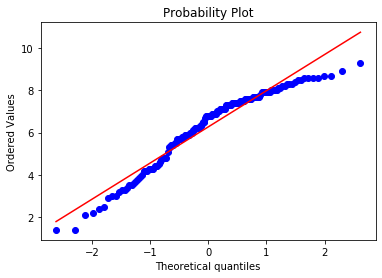

In [29]:
#проверка распределения на нормальность
res=st.probplot(pc_user_score, plot=plt)

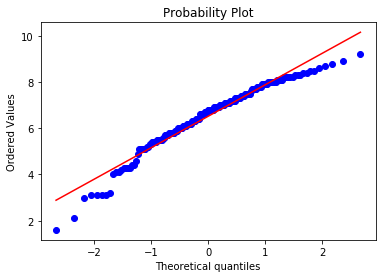

In [30]:
res=st.probplot(x_one_user_score, plot=plt)

In [31]:
results=st.ttest_ind(pc_user_score, x_one_user_score)
print('p_value равно ', results.pvalue)
print('Среднее значение пользовательского рейтинга платформы PC:', pc_user_score.median())
print('Среднее значение пользовательского рейтинга платформы XOne:', x_one_user_score.median())

if(results.pvalue<alpha):
    print('Отвергаем нулевую гипотезу')
else:
    print('Не получилось отвергнуть нулевую гипотезу')

p_value равно  0.14012658403611647
Среднее значение пользовательского рейтинга платформы PC: 6.8
Среднее значение пользовательского рейтинга платформы XOne: 6.8
Не получилось отвергнуть нулевую гипотезу


<b>Вывод:</b>
Не удалось отвергнуть о равенстве пользовательских рейтингов игр на платформах PC и Xone. Хотя, судя по средним значениям рейтинг игр на платформе PC несколько больше, семпла оказалось недостаточно, чтобы отвергнуть гипотезу о равенстве.

#### H0. Cредние пользовательские рейтинги жанров Action  и Sports одинаковые.
#### H1. Cредние пользовательские рейтинги жанров Action  и Sports разные.

In [32]:
action_user_score=df_2013_2016.query('genre=="Action"')['user_score'].dropna()
sport_user_score=df_2013_2016.query('genre=="Sports"')['user_score'].dropna()

results=st.ttest_ind(action_user_score, sport_user_score)
print('p_value равно ', results.pvalue)
print('Среднее значение пользовательского рейтинга игр в жанре Action:', action_user_score.median())
print('Среднее значение пользовательского рейтинга игр в жанре Sport:', sport_user_score.median())

if(results.pvalue<alpha):
    print('Отвергаем нулевую гипотезу')
else:
    print('Не получилось отвергнуть нулевую гипотезу')

p_value равно  1.0517832389140023e-27
Среднее значение пользовательского рейтинга игр в жанре Action: 7.1
Среднее значение пользовательского рейтинга игр в жанре Sport: 5.5
Отвергаем нулевую гипотезу


<b>Вывод:</b>
Отвергаем гипотезу о равенстве пользовательских рейтингов игр в жанрах экшн и спорт. Похоже жанр экшн любят больше.

## Общие выводы: <a class="anchor" id="6"></a>
<ol>
<li> Штаты являются самым крупным рынком компьютерных игр, на втором месте Европе, на третьем Япония и остальны страны. Доля остальных стран сравнима с японским рынком.  
<li>Наиболее перспективные и активно развивающиеся платформы на конец 2016 года -  Sony PS4, XOne и Nintendo 3DS
<li> При этом средняя стоимость игр на платформах различается и наиболее высокодоходными являются игры для X360, Sony PS4 и Sony PS3. С учетом п.1, имеет смысл в первую очередь обратить внимание на PS4, поскольку это новая платформа, являющаяся реинкарнацией PS3 и имеющая большой потенциал с одной стороны и пока еще не слишком большое количество игр под нее.
<li>На продажи игр влияют отзывы, причем отзывы критиков в большей степени. Поэтому имеет смысл выделить на это отдельный бюджет, особенно на американском и европейском рынках.
<li> Игры на платформе Sony наиболее популярны в Европе, в Штатах большую популярность имеет Xbox, в Японии Ниндендо. Можно ожидать, что новое поколение платформ этих брендов может распределиться подобным же образом. И с этой точки зрения на европейском рынке имеет смысл продвигать игры на PS4, в Штатах - для Xone, а в Японии - 3DS. Если же по каким-либо причинам невозможно (например, выбор игр выпущенных нашей компаней сильно ограничен или ограничен бюджет), то приоритет лучше отдать играм на PS4, поскольку они достаточно популярны на всех рынках.
<li> На конец 2016 года в Штатах и Европе самыми популярными и прибыльными являются шутеры и экшн, в Японии - ролевые. Если выбирать наиболее универсальный жанр для всех рынков - это Action.
<li> игры с отметкой М (для взрослых) и Т(для подростков) являются наиболее популярным. В Штатах также популярна категория E10+ (для детей старше 10 лет), но ее доля по продажам меньше.
<li> Гипотеза подтвердила, что пользовательские рейтинги жарнов Экшн и Спорт не равны, мы сделали вывод, что пользоватем в среднем больше нравится жарн Экшн, что еще раз подтвержает наши выводы. Жанр Спорт популярен в Европе и Штатах, но не на других рынках.